# Visualizing wavefunctions for a particle in different boxes 
### Anil Bilgin 
### 10/20/2024 

## Introduction to "Particle in a Box" in Quantum Mechanics

The "particle in a box" problem is a cornerstone of quantum mechanics, illustrating the fundamental principles of quantization, wavefunctions, and energy levels. It models a particle confined to a region of space (the "box") with infinitely high potential walls outside, preventing the particle from escaping. Within the box, the particle behaves as a quantum object, described by a wavefunction $\psi (x)$ that satisfies the Schrödinger equation. The particle's allowed energy states are quantized, leading to discrete energy levels.

This concept serves as a foundation for understanding more complex systems in quantum mechanics, such as atoms, molecules, and nanostructures. In this tutorial, we will explore how to simulate and solve the "particle in a box" numerically using Python. We'll begin with the simplest case of an infinite potential well and gradually extend the analysis to more complex systems, such as finite potential wells, the quantum harmonic oscillator and other arbitrary potential shapes. 

## 1. The infinite potential well

The simplest form of the particle in a box model is a one-dimensional system where the particle can move back and forth in a straight line with impenetrable walls at both ends. The walls of the box can be regarded as a region with infinitely large potential energy. Conversely, the interior of the box has zero potential energy. This means that the particle can move freely inside the box, but it won't be able to escape outside the box. The potential energy describing the infinite well is given by: 

$V(x) = \Bigg\{ 
\begin{array}{ll}
      0 & -\frac{L}{2} < x < \frac{L}{2} \\
      \infty & \textrm{otherwise} \\
\end{array}$

where $L$ is the length of the box. The wavefunctions that describe the behavior of the particle can be found by solving the time-independent Schrödinger equation for the system 

$-\displaystyle \frac{\hbar^2}{2 m} \displaystyle \frac{d^2}{dx^2} \psi(x) + V(x) \psi(x) = E \psi(x)$

where $\hbar$ is the reduced Planck's constant and $m$ is the mass of the particle. The solutions of the time-independent Schrödinger equation for the infinite potential well are already known, and you can read more about them here: (https://en.wikipedia.org/wiki/Particle_in_a_box) 

Here we will outline the steps of solving this equation and obtaining the wavefunctions numerically. 

1. We will first construct the Hamiltonian using a finite-difference method to approximate the second derivative in the Schrödinger equation.

2. The Hamiltonian matrix is then diagonalized to find the eigenvalues (energy levels) and the eigenvectors (wavefunctions)

3. The wavefunctions are normalized over the spatial grid & visualized 


Let's set $\hbar = 1$ and $m = 1$ for simplicity. With this simplification, we can rewrite the kinetic energy term at a point $x_i$ with the finite difference approximation

$-\displaystyle \frac{1}{2} \frac{d^2 \psi(x_i)}{d x^2} \approx  \displaystyle -\frac{\psi(x_{i-1}) - 2 \psi(x_i) + \psi(x_{i+1})}{2 \Delta x^2}, \ \ \ \ \ \ \text{where} \ \Delta x = x_{i+1} - x_i$

To construct the kinetic energy operator as a matrix, we encode this finite-difference formula into a sparse matrix acting on the wavefunction $\psi(x)$. For a grid of $n_{points}$, we use the following logic: 

- **Diagonal elements** $(-2/\Delta x^2)$: These represent the $-2 \psi(x_i)$ term in the second derivative formula.
- **Off-Diagonal elements** $(1/\Delta x^2)$: These represent the $\psi(x_{i-1})$ and $\psi(x_{i+1})$ terms.

The resulting matrix is a tridiagonal matrix that represents the discrete second derivative operator scaled by the kinetic energy prefactor. For example, for $n_{points} = 5$, the matrix would look like: 

$K = \displaystyle -\frac{1}{2 \Delta x^2} 
\displaystyle \begin{bmatrix}
-2 & 1 & 0 & 0 & 0 \\ 
1 & -2 & 1 & 0 & 0 \\ 
0 & 1 & -2 & 1 & 0 \\ 
0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 1 & -2 \\
\end{bmatrix}$

With this information in mind, now let's take a look at how we can write the function to solve the infinite potential well. 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sympy import symbols, diff, lambdify, Eq, solve
from sympy.abc import x as sym_x
from scipy.optimize import curve_fit

In [2]:
def infinite_potential_well(n_points, n_states, L):
    
    # Discretize the space
    x = np.linspace(-L/2, L/2, n_points)
    dx = x[1] - x[0]

    # Zero potential everywhere, except the boundary conditions (infinite)
    V = np.zeros(n_points)

    # Construct the Hamiltonian matrix using finite differences
    # Kinetic term: -1/(2m) d^2/dx^2 (set m=1, hbar=1 for simplicity)
    # We use n_points-2 to later add boundary points at x=0 and x=L
    kinetic = (-2 * np.eye(n_points-2) + np.eye(n_points-2, k=1) + np.eye(n_points-2, k=-1)) / (-2 * dx**2)

    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(kinetic)

    # Take the first n_states eigenvalues and eigenvectors
    energy_levels = eigenvalues[:n_states]
    wavefunctions = eigenvectors[:, :n_states]
    
    # Normalize the wavefunctions
    wavefunctions = wavefunctions / np.sqrt(np.sum(wavefunctions**2, axis=0) * dx)

    # Add boundary points (0 at x=0 and x=L)
    wavefunctions_full = np.zeros((n_points, n_states))
    wavefunctions_full[1:-1, :] = wavefunctions

    return x, V, energy_levels, wavefunctions_full

With the Python function for solving the infinite potential well now implemented, we can go beyond simply visualizing the wavefunctions and energy levels. A deeper understanding of the quantum states comes from calculating important physical quantities, such as the average position $\langle x \rangle$ and momentum $\langle p \rangle$, as well as their squared counterparts $\langle x^2 \rangle$ and $\langle p^2 \rangle$. These quantities not only help characterize the behavior of the particle within the box but also provide insights into the inherent uncertainties of quantum mechanics, such as $\sigma_x$ and $\sigma_p$, which are tied to Heisenberg's uncertainty principle.


Let's develop some supporting functions to compute the expectation values and uncertainties in position directly from the wavefunctions. These computations will not only reinforce the concepts of quantum operators but also illustrate numerical tools needed to extract meaningful physical quantities from simulated quantum states. 

The expressions for $\langle x \rangle$, $\langle x^2 \rangle$, and $\sigma_x$ are as follows: 

- $\langle x \rangle = \displaystyle \sum x |\psi(x)|^2 \Delta x$
  
- $\langle x^2 \rangle = \displaystyle \sum x^2 |\psi(x)|^2 \Delta x$

- $\sigma_x = \sqrt{\langle x^2 \rangle - \langle x \rangle^2}$

In [3]:
def calculate_average_x(x, wavefunctions):
    dx = x[1] - x[0]
    probabilities = wavefunctions**2 
    average_positions = np.sum(x[:, np.newaxis] * probabilities, axis=0) * dx 
    return average_positions


def calculate_average_x_squared(x, wavefunctions):
    dx = x[1] - x[0]
    probabilities = wavefunctions**2 
    average_x_squared = np.sum((x[:, np.newaxis]**2) * probabilities, axis=0) * dx 
    return average_x_squared


def calculate_uncertainty_x(x, wavefunctions): 
    average_x = calculate_average_x(x, wavefunctions) 
    average_x_squared = calculate_average_x_squared(x, wavefunctions) 
    uncertainties = np.sqrt(average_x_squared - average_x**2)
    return uncertainties 


Similarly, we are going to need functions to help us determine all the same quantities for momentum $p$. In quantum mechanics, momentum is represented by an operator involving a derivative, and its expectation values are calculated in a similar fashion to those for position. The one dimensional momentum operator expressed in position representation is: 

$\hat{p} = -i \hbar \displaystyle \frac{\partial}{\partial x}$

With the simplification that $\hbar = 1$ and using the finite-difference method for approximating derivatives, the expressions for $\langle p \rangle$, $\langle p^2 \rangle$ and $\sigma_p$ are given by:   

- $\langle p \rangle = \displaystyle \int \psi(x)^{*} \Big(-i \frac{\partial}{\partial x}\Big) \psi(x) dx \ \ \ \ \ \ \  \text{becomes} \ \ \ \ \ \langle p \rangle \approx \displaystyle \sum \psi(x)^{*} \Bigg( -i \frac{ \psi(x + \Delta x) - \psi(x - \Delta x)}{2 \Delta x} \Bigg) \Delta x$

- $\langle p^2 \rangle = \displaystyle \int \psi(x)^{*} \Big(-\frac{\partial^2}{\partial x^2}\Big) \psi(x) dx \ \ \ \ \  \text{becomes} \ \ \ \ \ \langle p \rangle \approx \displaystyle \sum \psi(x)^{*} \Bigg( - \frac{ \psi(x + \Delta x) - 2 \psi(x)+ \psi(x - \Delta x)}{\Delta x^2} \Bigg) \Delta x$

- $\sigma_p = \sqrt{\langle p^2 \rangle - \langle p \rangle^2}$


In [4]:
def calculate_average_momenta(x, wavefunctions):
    n_points, n_states = wavefunctions.shape 
    average_momenta = np.zeros(n_states, dtype=np.complex128)  # Momentum can be complex
    dx = x[1] - x[0]
    
    # Finite difference for first derivative 
    for i in range(1, n_points - 1):  # Avoid boundaries 
        dpsi_dx = (wavefunctions[i + 1, :] - wavefunctions[i - 1, :]) / (2 * dx)
        average_momenta += np.conj(wavefunctions[i, :]) * (-1j * dpsi_dx)

    average_momenta *= dx 
    return average_momenta.real  # <p> is expected to be real for bound states 


def calculate_average_momenta_squared(x, wavefunctions):
    n_points, n_states = wavefunctions.shape 
    average_momenta_squared = np.zeros(n_states)  
    dx = x[1] - x[0]
    
    # Finite difference for second derivative 
    for i in range(1, n_points - 1):  # Avoid boundaries 
        d2psi_dx2 = (wavefunctions[i + 1, :] - 2 * wavefunctions[i, :] + wavefunctions[i - 1, :]) / (dx**2)
        average_momenta_squared += np.conj(wavefunctions[i, :]) * (-d2psi_dx2)

    average_momenta_squared *= dx 
    return average_momenta_squared.real


def calculate_uncertainty_p(x, wavefunctions):
    average_p = calculate_average_momenta(x, wavefunctions) 
    average_p_squared = calculate_average_momenta_squared(x, wavefunctions) 
    uncertainties = np.sqrt(average_p_squared - average_p**2) 
    return uncertainties 


With all the tools we laid out above, we can now compute the wavefunctions of the infinite potential well by solving the Schrödinger equation. In this next step, we’ll use the previously defined functions to analyze the solutions in detail. For each wavefunction, we’ll calculate and print the corresponding average position $\langle x \rangle$, momentum $\langle p \rangle$, and their uncertainties $\sigma_x$, $\sigma_p$. This will provide a comprehensive view of the particle's behavior in the infinite potential well, reinforcing both the numerical techniques and the physical insights of quantum mechanics. 

n	E(n)		<x>	<x^2>	σx		<p>	<p^2>	σp		σxσp
-----------------------------------------------------------------------------------------------
1	0.3084		0.0000	0.5228	0.7230		0.0000	0.6169	0.7854		0.5679
2	1.2337		0.0000	1.1307	1.0633		0.0000	2.4674	1.5708		1.6703
3	2.7758		0.0000	1.2433	1.1150		0.0000	5.5516	2.3562		2.6272
4	4.9348		0.0000	1.2827	1.1326		0.0000	9.8696	3.1416		3.5580
5	7.7106		0.0000	1.3009	1.1406		0.0000	15.4212	3.9270		4.4790
6	11.1032		0.0000	1.3108	1.1449		0.0000	22.2064	4.7124		5.3952
7	15.1127		0.0000	1.3168	1.1475		0.0000	30.2254	5.4978		6.3088
8	19.7389		0.0000	1.3207	1.1492		0.0000	39.4779	6.2831		7.2206
9	24.9820		0.0000	1.3233	1.1504		0.0000	49.9640	7.0685		8.1313
10	30.8419		0.0000	1.3252	1.1512		0.0000	61.6838	7.8539		9.0413




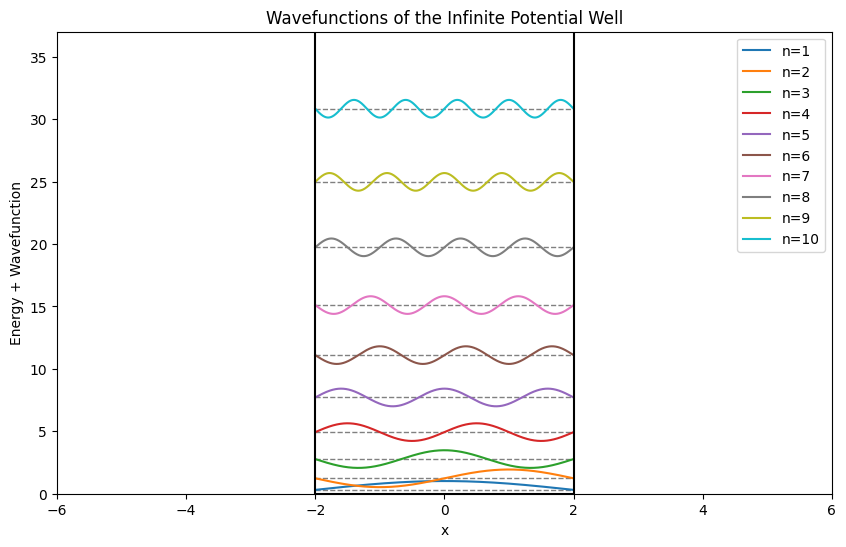

In [5]:
# Parameters
n_points = 2001         # Discretization of space (x) 
n_states = 10           # Number of states of interest
L = 4.0                 # Size of the box 

# Infinite potential well 
x, V, energy_levels, wavefunctions = infinite_potential_well(n_points, n_states, L)

# Calculating <p>, <p^2>, <x>, <x^2> and uncertainties 
average_x = calculate_average_x(x, wavefunctions)
average_x_squared = calculate_average_x_squared(x, wavefunctions)
uncertainties_x = calculate_uncertainty_x(x, wavefunctions)
average_p = calculate_average_momenta(x, wavefunctions)
average_p_squared = calculate_average_momenta_squared(x, wavefunctions)
uncertainties_p = calculate_uncertainty_p(x, wavefunctions) 
uncertainty_products = uncertainties_x * uncertainties_p

# Display relevant information 
for i in range(len(energy_levels)):
    energy = energy_levels[i] 
    x_avg = average_x[i]
    x2_avg = average_x_squared[i]
    sigma_x = uncertainties_x[i]
    p_avg = average_p[i]
    p2_avg= average_p_squared[i]
    sigma_p = uncertainties_p[i]
    
    row_info = [i+1, energy, abs(x_avg), x2_avg, sigma_x, abs(p_avg), p2_avg, sigma_p, sigma_p*sigma_x]
    
    if (i == 0): 
        print(f"n\tE(n)\t\t<x>\t<x^2>\tσx\t\t<p>\t<p^2>\tσp\t\tσxσp")
        print("-" * 95)
    print("{}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}".format(*row_info))
    if (i == len(energy_levels) - 1): print("\n")


# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_states):
    plt.hlines(y=energy_levels[i], xmin=-L/2, xmax=L/2, color='gray', linestyle='--', linewidth=1.0)
    plt.plot(x, wavefunctions[:, i] + energy_levels[i], label=f'n={i+1}')

# Define the boundaries of the box 
plt.vlines(-L/2, 0, 2*energy_levels[-1], color='black')
plt.vlines(L/2, 0, 2*energy_levels[-1], color='black')
plt.hlines(y=0, xmin=-L/2, xmax=L/2, color='black')

tick_locations = [-3*L/2, -L, -L/2, 0, L/2, L, 3*L/2]
ax.set_xticks(tick_locations)
plt.ylim(0, energy_levels[-1] * 1.2 )
plt.title('Wavefunctions of the Infinite Potential Well')
plt.xlabel('x')
plt.ylabel('Energy + Wavefunction')
plt.legend()
plt.show()

The results of our computations reveal key insights into the nature of quantum mechanics. First, the wavefunctions of the infinite potential well exhibit well-defined nodes and antinodes, reflecting the quantization of energy levels and the requirement for the wavefunctions to satisfy boundary conditions. The symmetry of these wavefunctions around the center of the well explains why the average position $\langle x \rangle$ and momentum $\langle p \rangle$ are zero for all states. Since the box is perfectly symmetric around the center $x = 0$, the particle is equally likely to be on the left and on the right side of the box. Similarly, the particle is equally likely to move left or right within the box, resulting in zero average momentum. This also makes intuitive sense since the particle is confined within the box and cannot escape. If the particle had non-zero average momentum, it would have to eventually escape the box and go elsewhere.  

The expectation values $\langle x^2 \rangle$, $\langle p^2 \rangle$ and the derived uncertainties, $\sigma_x$ and $\sigma_p$, reveal an important trend: Both uncertainties increase with the energy level $n$. This also makes sense, as higher energy states correspond to wavefunctions that are more spread out spatially, increasing $\sigma_x$, while simultaneously possessing higher momentum components, which increase $\sigma_p$. The interplay between these uncertainties is consistent with Heisenberg's uncertainty principle, demonstrating that the uncertainty product $\sigma_x \sigma_p$ grows with the particle's energy.

Having explored and commented on the computed wavefunctions, expectation values and uncertainties, a natural next step is to delve deeper into how these quantities scale with the energy level $n$. Understanding these scaling laws can shed some light into the behavior of quantum systems as they move to higher energy states. For instance, the scalings of energy $E_n$, $\sigma_x$, $\sigma_p$ are well-known. Let's test to see how well our predicted dependencies match with the known scaling laws.  


The scaling of the energy eigenvalues for the infinite potential well are given by $E_n = \displaystyle \frac{\hbar^2 \pi^2}{2 m L^2} n^2$

The scaling for the variances in position $\sigma_x^2$ and momentum $\sigma_p^2$, which in our case reduce to $\langle x^2 \rangle$ and $\langle p^2 \rangle$ since $\langle x \rangle = \langle p \rangle = 0$ 

- $\sigma_x^2 = \langle x^2 \rangle = \displaystyle \frac{L^2}{12} \Bigg(1 - \frac{6}{n^2 \pi^2} \Bigg)$

- $\sigma_p^2 = \langle p^2 \rangle = \Big( \displaystyle \frac{\hbar \pi n}{L} \Big)^2$


E = 0.3084 * n**2 + 0.0001
Var(p) = 0.6168 * n**2 + 0.0001
Var(x) = -0.8106 * 1/(n**2) + 1.3333



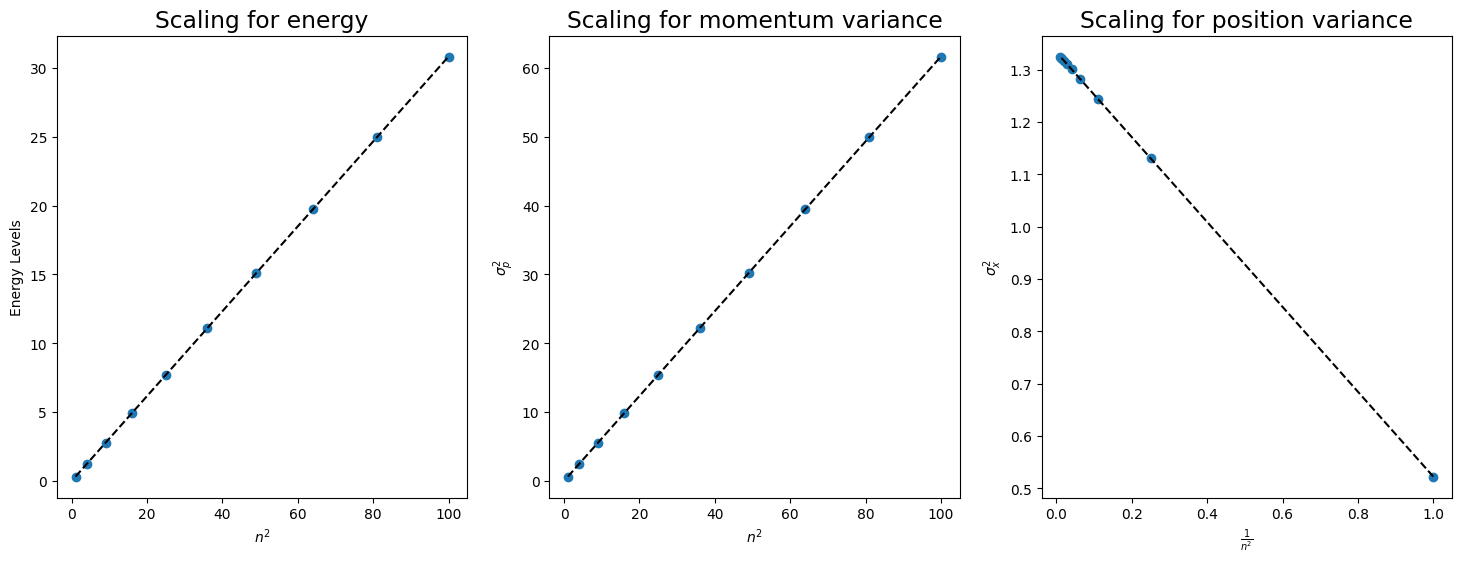

In [6]:
# Prepare fitting with n**2 
n = np.linspace(1, n_states, n_states)
n_squared = n ** 2

# Linear fitting to data points
def line_fit(x, a, b):
	return a * x + b

# Curve fitting with respect to n**2 for energy and uncertainty in momentum, 
# with respect to 1 / n**2 for uncertainty in position. 
fit_energy, _ = curve_fit(line_fit, n_squared, energy_levels)
fit_uncertainty_p, _ = curve_fit(line_fit, n_squared, average_p_squared)
fit_uncertainty_x, _ = curve_fit(line_fit, 1 / n_squared, average_x_squared)

# Extracting fit parameters
a_ene, b_ene = fit_energy
a_p, b_p = fit_uncertainty_p
a_x, b_x = fit_uncertainty_x

# Creating a fit line for comparison
fit_line_ene = line_fit(n_squared, a_ene, b_ene)
fit_line_p = line_fit(n_squared, a_p, b_p)
fit_line_x = line_fit(1 / n_squared, a_x, b_x)

# Print fitting parameters
print(f"E = {a_ene:>.4f} * n**2 + {b_ene:>.4f}")
print(f"Var(p) = {a_p:>.4f} * n**2 + {b_p:>.4f}")
print(f"Var(x) = {a_x:>.4f} * 1/(n**2) + {b_x:>.4f}\n")

### Plotting ###
fig, ax = plt.subplots(1,3, figsize=(18, 6))
plt.rcParams.update({'font.size': 14})


# Scaling for energy 
ax[0].scatter(n_squared, energy_levels)
ax[0].plot(n_squared, fit_line_ene, '--', color='k')
ax[0].set_title('Scaling for energy')
ax[0].set_xlabel('$n^2$')
ax[0].set_ylabel('Energy Levels')

# Scaling for momentum variance
ax[1].scatter(n_squared, average_p_squared)
ax[1].plot(n_squared, fit_line_p, '--', color='k')
ax[1].set_title('Scaling for momentum variance')
ax[1].set_xlabel('$n^2$')
ax[1].set_ylabel('$\sigma_p^2$')

# Scaling for position variance 
ax[2].scatter(1 / n_squared, average_x_squared)
ax[2].plot(1 / n_squared, fit_line_x, '--', color='k')
ax[2].set_title('Scaling for position variance')
ax[2].set_xlabel('$\\frac{1}{n^2}$')
ax[2].set_ylabel('$\sigma_x^2$')

plt.show()

From the fit parameters we obtained above, here's how each of the fits match with their theoretical values (with $\hbar = 1, m=1, L=4$)

 - $E_n = \displaystyle \frac{\hbar^2 \pi^2}{2 m L^2} n^2 = 0.3084 \cdot  n^2 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ E_n \approx 0.3084 \cdot n^2 \ \ \ \  \text{from fit}$

 - $\sigma_p^2 = \displaystyle \frac{\hbar^2 \pi^2}{L^2} n^2 = 0.6169 \cdot n^2 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ \  \sigma_p^2 \approx 0.6168 \cdot n^2 \ \ \ \ \text{from fit}$

 - $\sigma_x^2 = \displaystyle \frac{L^2}{12} - \frac{6 L^2}{12 \pi^2} \frac{1}{n^2} = 1.3333 - 0.8106 \cdot \frac{1}{n^2} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ \sigma_x^2 = 1.3333 - 0.8106 \frac{1}{n^2}  \ \ \ \ \ \text{from fit}$





## 2. The Finite potential well

In the infinite potential well, we explored a scenario where a particle is confined within rigid, impenetrable walls, resulting in quantized energy levels and wavefunctions that vanish entirely at the boundaries. While this idealized model provides valuable insights into quantum confinement, real-world systems often involve finite potential wells, where the walls are not infinitely high. In a finite potential well, the particle experiences a potential that allows for the possibility of "leaking" into classically forbidden regions beyond the well boundaries. This introduces a key distinction: the wavefunctions no longer vanish abruptly at the edges but decay exponentially into the surrounding regions. Despite this difference, the finite potential well retains some similarities to the infinite case, such as quantized energy levels and standing-wave solutions inside the well. However, the finite depth of the well means that not all energy levels are bound states, and higher-energy particles may escape entirely. Let’s delve into the finite potential well to explore how these adjustments affect the quantum behavior of particles. 

We start by adjusting our potential to look like this:  

$V(x) = \Bigg\{ 
\begin{array}{ll}
      0 & -\frac{L}{2} < x < \frac{L}{2} \\
      V_0 & \textrm{otherwise} \\
\end{array}$


In [7]:
def finite_potential_well(n_points, n_states, L, barrier_height): 

    # Discretize the space 
    x_min, x_max = -L, L  # Define a range wider than the well
    x = np.linspace(x_min, x_max, n_points)
    dx = x[1] - x[0]

    # Define the potential: V(x) = 0 inside [-L/2, L/2], V(x) = barrier_height otherwise
    V = np.full_like(x, barrier_height)
    V[(x >= -L/2) & (x <= L/2)] = 0

    # Construct the Hamiltonian matrix using finite differences
    # Kinetic term: -1/(2m) d^2/dx^2 (set m=1, hbar=1 for simplicity)
    kinetic = (-2 * np.eye(n_points) + np.eye(n_points, k=1) + np.eye(n_points, k=-1)) / (-2 * dx**2)
    potential = np.diag(V) 
    H = kinetic + potential

    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Take the first n_states eigenvalues and eigenvectors
    energy_levels = eigenvalues[:n_states]
    wavefunctions = eigenvectors[:, :n_states]

    # Normalize the wavefunctions
    wavefunctions = wavefunctions / np.sqrt(np.sum(wavefunctions**2, axis=0) * dx)

    return x, V, energy_levels, wavefunctions

Above, we embed the finite potential well in a slightly larger, infinite potential well. The finite well is between $-L/2$ and $L/2$ while the infinite stretches from $-L$ to $L$. 


### 2.1 The finite potential well with $V_0 = 0$
Let's think about the case where the finite potential $V_0 = 0$. This means that we should recover the same results as the infinite potential well, but for a larger value of $L$. In the first example our infinite well stretched from $-L/2$ to $L/2$ with $L = 4$. Now we should expect to see an infinite potential well from $-L$ to $L$ with $L=4$ for an effective total length $L_{eff} = 8$.  

n	E(n)		<x>	<x^2>	σx		<p>	<p^2>	σp		σxσp
-----------------------------------------------------------------------------------------------
1	0.0770		0.0000	2.0952	1.4475		0.0000	0.1539	0.3923		0.5679
2	0.3078		0.0000	4.5318	2.1288		0.0000	0.6156	0.7846		1.6703
3	0.6926		0.0000	4.9830	2.2323		0.0000	1.3851	1.1769		2.6272
4	1.2312		0.0000	5.1410	2.2674		0.0000	2.4625	1.5692		3.5580
5	1.9238		0.0000	5.2141	2.2834		0.0000	3.8476	1.9615		4.4790
6	2.7703		0.0000	5.2538	2.2921		0.0000	5.5405	2.3538		5.3952
7	3.7706		0.0000	5.2777	2.2973		0.0000	7.5412	2.7461		6.3088
8	4.9249		0.0000	5.2932	2.3007		0.0000	9.8498	3.1384		7.2206
9	6.2330		0.0000	5.3039	2.3030		0.0000	12.4661	3.5307		8.1313
10	7.6951		0.0000	5.3115	2.3047		0.0000	15.3901	3.9230		9.0413




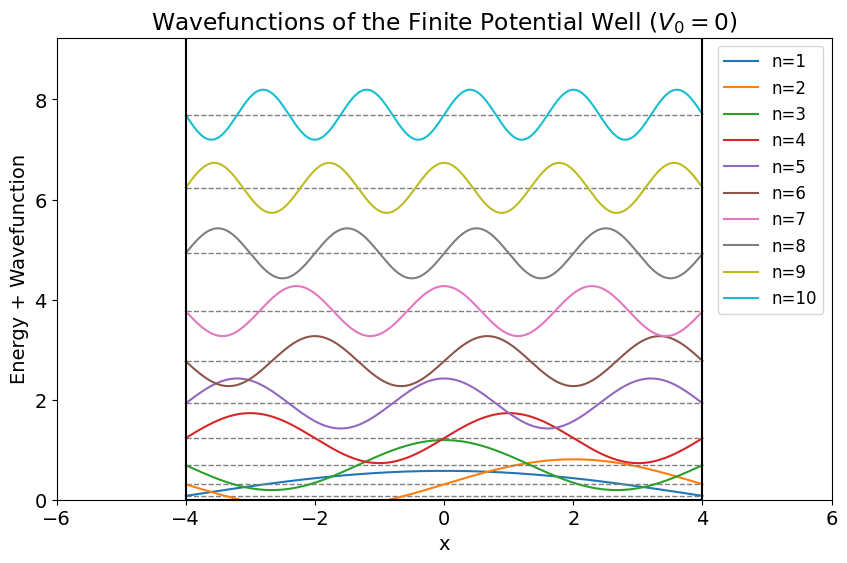

In [8]:
# Parameters
n_points = 2001         # Discretization of space (x) 
n_states = 10           # Number of states of interest
L = 4.0                 # Size of the box 
barrier_height = 0      # Height of the finite potential barrier

# Finite potential well 
x, V, energy_levels, wavefunctions = finite_potential_well(n_points, n_states, L, barrier_height)

# Calculating <p>, <p^2>, <x>, <x^2> and uncertainties 
average_x = calculate_average_x(x, wavefunctions)
average_x_squared = calculate_average_x_squared(x, wavefunctions)
uncertainties_x = calculate_uncertainty_x(x, wavefunctions)
average_p = calculate_average_momenta(x, wavefunctions)
average_p_squared = calculate_average_momenta_squared(x, wavefunctions)
uncertainties_p = calculate_uncertainty_p(x, wavefunctions) 
uncertainty_products = uncertainties_x * uncertainties_p


# Display relevant information 
for i in range(len(energy_levels)):
    energy = energy_levels[i] 
    x_avg = average_x[i]
    x2_avg = average_x_squared[i]
    sigma_x = uncertainties_x[i]
    p_avg = average_p[i]
    p2_avg= average_p_squared[i]
    sigma_p = uncertainties_p[i]

    row_info = [i+1, energy, abs(x_avg), x2_avg, sigma_x, abs(p_avg), p2_avg, sigma_p, sigma_p*sigma_x]
    
    if (i == 0): 
        print(f"n\tE(n)\t\t<x>\t<x^2>\tσx\t\t<p>\t<p^2>\tσp\t\tσxσp")
        print("-" * 95)
    print("{}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}".format(*row_info))
    if (i == len(energy_levels) - 1): print("\n")
    

# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_states):
    plt.hlines(y=energy_levels[i], xmin=-L, xmax=L, color='gray', linestyle='--', linewidth=1.0)
    plt.plot(x, wavefunctions[:, i] + energy_levels[i], label=f'n={i+1}')

# Define the boundaries of the (hard, infinite) box 
plt.vlines(-L, 0, 2*energy_levels[-1], color='black')
plt.vlines(L, 0, 2*energy_levels[-1], color='black')
plt.hlines(y=0, xmin=-L, xmax=L, color='black')

# Define where the barrier is 
plt.vlines(-L/2, 0, barrier_height, linestyle = '--', color='darkred')
plt.vlines(L/2, 0, barrier_height, linestyle = '--', color='darkred')

tick_locations = [-3*L/2, -L, -L/2, 0, L/2, L, 3*L/2]
ax.set_xticks(tick_locations)
plt.ylim(0, energy_levels[-1] * 1.2 )
plt.title('Wavefunctions of the Finite Potential Well ($V_0 = {}$)'.format(barrier_height))
plt.xlabel('x')
plt.ylabel('Energy + Wavefunction')
plt.legend(fontsize = '12')
plt.show()

E = 0.0770 * n**2 + 0.0000
Var(p) = 0.1539 * n**2 + 0.0000
Var(x) = -3.2488 * 1/(n**2) + 5.3440



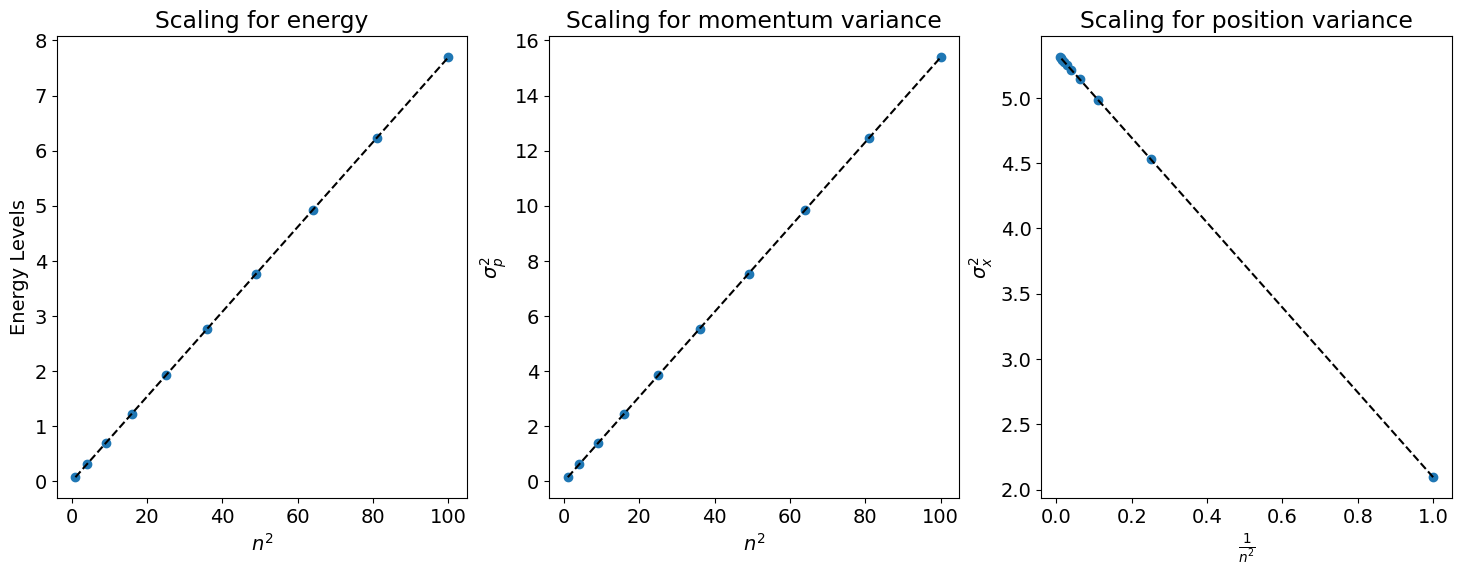

In [9]:
# Prepare fitting with n**2 
n = np.linspace(1, n_states, n_states)
n_squared = n ** 2

# Linear fitting to data points
def line_fit(x, a, b):
	return a * x + b

# Curve fitting with respect to n**2 for energy and uncertainty in momentum, 
# with respect to 1 / n**2 for uncertainty in position. 
fit_energy, _ = curve_fit(line_fit, n_squared, energy_levels)
fit_uncertainty_p, _ = curve_fit(line_fit, n_squared, average_p_squared)
fit_uncertainty_x, _ = curve_fit(line_fit, 1 / n_squared, average_x_squared)

# Extracting fit parameters
a_ene, b_ene = fit_energy
a_p, b_p = fit_uncertainty_p
a_x, b_x = fit_uncertainty_x

# Creating a fit line for comparison
fit_line_ene = line_fit(n_squared, a_ene, b_ene)
fit_line_p = line_fit(n_squared, a_p, b_p)
fit_line_x = line_fit(1 / n_squared, a_x, b_x)

# Print fitting parameters
print(f"E = {a_ene:>.4f} * n**2 + {b_ene:>.4f}")
print(f"Var(p) = {a_p:>.4f} * n**2 + {b_p:>.4f}")
print(f"Var(x) = {a_x:>.4f} * 1/(n**2) + {b_x:>.4f}\n")

### Plotting ###
fig, ax = plt.subplots(1,3, figsize=(18, 6))
plt.rcParams.update({'font.size': 14})


# Scaling for energy 
ax[0].scatter(n_squared, energy_levels)
ax[0].plot(n_squared, fit_line_ene, '--', color='k')
ax[0].set_title('Scaling for energy')
ax[0].set_xlabel('$n^2$')
ax[0].set_ylabel('Energy Levels')

# Scaling for momentum variance
ax[1].scatter(n_squared, average_p_squared)
ax[1].plot(n_squared, fit_line_p, '--', color='k')
ax[1].set_title('Scaling for momentum variance')
ax[1].set_xlabel('$n^2$')
ax[1].set_ylabel('$\sigma_p^2$')

# Scaling for position variance 
ax[2].scatter(1 / n_squared, average_x_squared)
ax[2].plot(1 / n_squared, fit_line_x, '--', color='k')
ax[2].set_title('Scaling for position variance')
ax[2].set_xlabel('$\\frac{1}{n^2}$')
ax[2].set_ylabel('$\sigma_x^2$')

plt.show()

We see from the fit parameters above that we successfully recovered the infinite potential well with $L_{eff} = 8$ (and $\hbar = 1, m=1$)

 - $E_n = \displaystyle \frac{\hbar^2 \pi^2}{2 m L^2} n^2 = 0.0771 \cdot  n^2 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ E_n \approx 0.0770 \cdot n^2 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{from fit}$

 - $\sigma_p^2 = \displaystyle \frac{\hbar^2 \pi^2}{L^2} n^2 = 0.1542 \cdot n^2 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ \  \sigma_p^2 \approx 0.1539 \cdot n^2 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{from fit}$

 - $\sigma_x^2 = \displaystyle \frac{L^2}{12} - \frac{6 L^2}{12 \pi^2} \frac{1}{n^2} = 5.3333 - 3.2423 \cdot \frac{1}{n^2} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ \sigma_x^2 = 5.3440 - 3.2488 \frac{1}{n^2}  \ \ \ \ \ \text{from fit}$


### 2.2 The finite potential well with $V_0 = 500$

Now let's consider pushing the finite potential to another extreme. If we set the finite potential $V_0$ to a very large (yet finite) number, we should again reproduce something that looks very similar to the infinite potential well. Try setting $V_0 = 500$

n	E(n)		<x>	<x^2>	σx		<p>	<p^2>	σp		σxσp
-----------------------------------------------------------------------------------------------
1	0.2983		0.0000	0.5405	0.7352		0.0000	0.5873	0.7664		0.5634
2	1.1932		0.0000	1.1692	1.0813		0.0000	2.3492	1.5327		1.6573
3	2.6845		0.0000	1.2856	1.1339		0.0000	5.2855	2.2990		2.6068
4	4.7724		0.0000	1.3264	1.1517		0.0000	9.3959	3.0653		3.5303
5	7.4566		0.0000	1.3454	1.1599		0.0000	14.6800	3.8315		4.4442
6	10.7370		0.0000	1.3558	1.1644		0.0000	21.1372	4.5975		5.3533
7	14.6135		0.0000	1.3622	1.1671		0.0000	28.7669	5.3635		6.2598
8	19.0859		0.0000	1.3664	1.1689		0.0000	37.5681	6.1293		7.1646
9	24.1540		0.0000	1.3693	1.1702		0.0000	47.5399	6.8949		8.0684
10	29.8175		0.0000	1.3716	1.1711		0.0000	58.6812	7.6604		8.9714




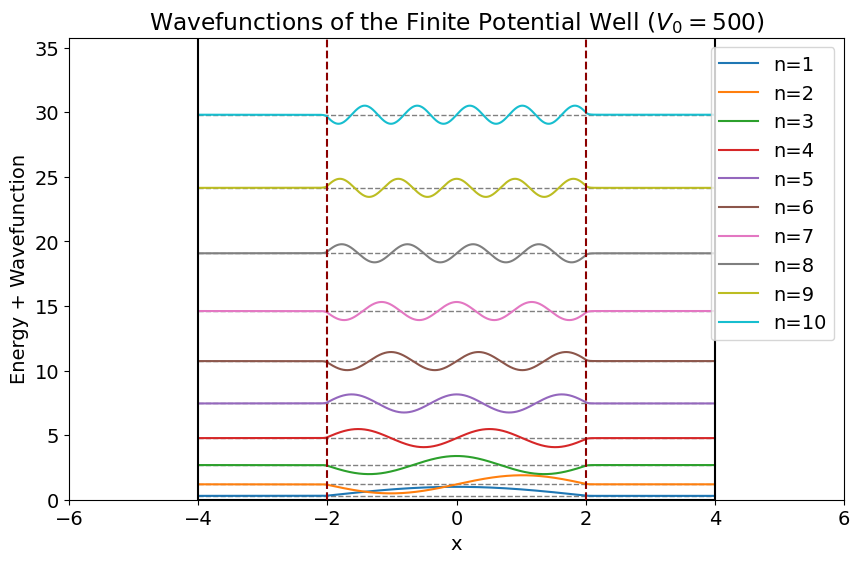

In [10]:
# Parameters
n_points = 2001         # Discretization of space (x) 
n_states = 10           # Number of states of interest
L = 4.0                 # Size of the box 
barrier_height = 500    # Height of the finite potential barrier

# Finite potential well 
x, V, energy_levels, wavefunctions = finite_potential_well(n_points, n_states, L, barrier_height)

# Calculating <p>, <p^2>, <x>, <x^2> and uncertainties 
average_x = calculate_average_x(x, wavefunctions)
average_x_squared = calculate_average_x_squared(x, wavefunctions)
uncertainties_x = calculate_uncertainty_x(x, wavefunctions)
average_p = calculate_average_momenta(x, wavefunctions)
average_p_squared = calculate_average_momenta_squared(x, wavefunctions)
uncertainties_p = calculate_uncertainty_p(x, wavefunctions) 
uncertainty_products = uncertainties_x * uncertainties_p


# Display relevant information 
for i in range(len(energy_levels)):
    energy = energy_levels[i] 
    x_avg = average_x[i]
    x2_avg = average_x_squared[i]
    sigma_x = uncertainties_x[i]
    p_avg = average_p[i]
    p2_avg= average_p_squared[i]
    sigma_p = uncertainties_p[i]

    row_info = [i+1, energy, abs(x_avg), x2_avg, sigma_x, abs(p_avg), p2_avg, sigma_p, sigma_p*sigma_x]
    
    if (i == 0): 
        print(f"n\tE(n)\t\t<x>\t<x^2>\tσx\t\t<p>\t<p^2>\tσp\t\tσxσp")
        print("-" * 95)
    print("{}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}".format(*row_info))
    if (i == len(energy_levels) - 1): print("\n")
        

# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_states):
    plt.hlines(y=energy_levels[i], xmin=-L, xmax=L, color='gray', linestyle='--', linewidth=1.0)
    plt.plot(x, wavefunctions[:, i] + energy_levels[i], label=f'n={i+1}')

# Define the boundaries of the (hard, infinite) box 
plt.vlines(-L, 0, 2*energy_levels[-1], color='black')
plt.vlines(L, 0, 2*energy_levels[-1], color='black')
plt.hlines(y=0, xmin=-L, xmax=L, color='black')

# Define where the barrier is 
plt.vlines(-L/2, 0, barrier_height, linestyle = '--', color='darkred')
plt.vlines(L/2, 0, barrier_height, linestyle = '--', color='darkred')

tick_locations = [-3*L/2, -L, -L/2, 0, L/2, L, 3*L/2]
ax.set_xticks(tick_locations)
plt.ylim(0, energy_levels[-1] * 1.2 )
plt.title('Wavefunctions of the Finite Potential Well ($V_0 = {})$'.format(barrier_height))
plt.xlabel('x')
plt.ylabel('Energy + Wavefunction')
plt.legend()
plt.show()

E = 0.2982 * n**2 + 0.0013
Var(p) = 0.5868 * n**2 + 0.0059
Var(x) = -0.8389 * 1/(n**2) + 1.3792



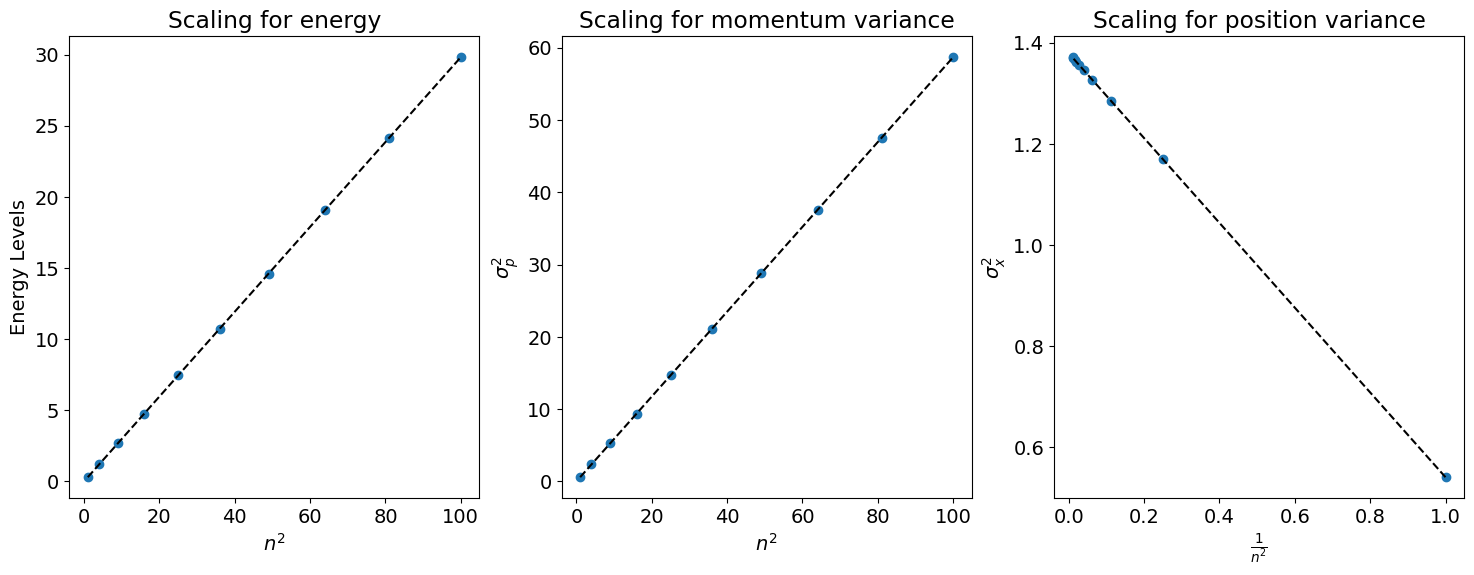

In [11]:
# Prepare fitting with n**2 
n = np.linspace(1, n_states, n_states)
n_squared = n ** 2

# Linear fitting to data points
def line_fit(x, a, b):
	return a * x + b

# Curve fitting with respect to n**2 for energy and uncertainty in momentum, 
# with respect to 1 / n**2 for uncertainty in position. 
fit_energy, _ = curve_fit(line_fit, n_squared, energy_levels)
fit_uncertainty_p, _ = curve_fit(line_fit, n_squared, average_p_squared)
fit_uncertainty_x, _ = curve_fit(line_fit, 1 / n_squared, average_x_squared)

# Extracting fit parameters
a_ene, b_ene = fit_energy
a_p, b_p = fit_uncertainty_p
a_x, b_x = fit_uncertainty_x

# Creating a fit line for comparison
fit_line_ene = line_fit(n_squared, a_ene, b_ene)
fit_line_p = line_fit(n_squared, a_p, b_p)
fit_line_x = line_fit(1 / n_squared, a_x, b_x)

# Print fitting parameters
print(f"E = {a_ene:>.4f} * n**2 + {b_ene:>.4f}")
print(f"Var(p) = {a_p:>.4f} * n**2 + {b_p:>.4f}")
print(f"Var(x) = {a_x:>.4f} * 1/(n**2) + {b_x:>.4f}\n")

### Plotting ###
fig, ax = plt.subplots(1,3, figsize=(18, 6))
plt.rcParams.update({'font.size': 14})


# Scaling for energy 
ax[0].scatter(n_squared, energy_levels)
ax[0].plot(n_squared, fit_line_ene, '--', color='k')
ax[0].set_title('Scaling for energy')
ax[0].set_xlabel('$n^2$')
ax[0].set_ylabel('Energy Levels')

# Scaling for momentum variance
ax[1].scatter(n_squared, average_p_squared)
ax[1].plot(n_squared, fit_line_p, '--', color='k')
ax[1].set_title('Scaling for momentum variance')
ax[1].set_xlabel('$n^2$')
ax[1].set_ylabel('$\sigma_p^2$')

# Scaling for position variance 
ax[2].scatter(1 / n_squared, average_x_squared)
ax[2].plot(1 / n_squared, fit_line_x, '--', color='k')
ax[2].set_title('Scaling for position variance')
ax[2].set_xlabel('$\\frac{1}{n^2}$')
ax[2].set_ylabel('$\sigma_x^2$')

plt.show()

The numerical results show that as the finite well becomes deeper, its behavior closely approximates that of the infinite well. Energy levels for lower states align closely, while wavefunctions remain nearly identical inside the well, with slight exponential decay outside. This highlights that the infinite well provides an excellent approximation for deep finite wells, particularly for low-energy bound states, capturing the key aspects of quantum confinement.

 - $E_n \approx 0.3084 \cdot n^2 \ \ \text{for} \ \ V_0 = \infty \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ \ \ \ \ E_n \approx 0.2982 \cdot n^2 \ \ \text{for} \ \ V_0 = 500$

 - $\sigma_p^2 \ \approx 0.6168 \cdot n^2 \ \ \text{for} \ \ V_0 = \infty \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ \ \ \ \ \sigma_p^2 \ \approx 0.5868 \cdot n^2 \ \ \text{for} \ \ V_0 = 500$

 - $\sigma_x^2 \ = 1.3333 - 0.8106 \cdot \displaystyle \frac{1}{n^2} \ \ \text{for} \ \ V_0 = \infty \ \ \ \ \ \ \ \ \ \ \ \ \ vs. \ \ \ \ \ \ \ \ \ \ \sigma_x^2 \ = 1.3792 - 0.8389 \cdot \displaystyle \frac{1}{n^2} \ \ \text{for} \ \ V_0 = 500$


### 2.3 The finite potential well with $V_0 = 20$

Finally, let's consider an in-between case where we set $V_0 = 20$, creating a much shallower potential barrier comparable to the energy of some higher energy wavefunctions from before. In this case, we should expect to see wavefunctions with energy greater than $V_0$ to "leak" out. Unlike the infinite well, where all energy states are strictly confined, the shallow finite well introduces a new behavior. While the lowest energy states remain bound and largely confined within the well, higher energy states can escape entirely. These unbound states correspond to particles that are no longer trapped and can exist freely outside the box (in this case they will still be trapped in our surrounding, larger infinite well). This setup provides a more realistic model of physical systems, such as quantum dots or atoms in shallow traps, and highlights the transition between bound and unbound states as the energy increases. In the next section, we’ll solve the Schrödinger equation for such a shallow finite well, visualize its wavefunctions, and investigate how the energy levels and wavefunctions differ from previous cases. 


n	E(n)		<x>	<x^2>	σx		<p>	<p^2>	σp		σxσp
-----------------------------------------------------------------------------------------------
1	0.2643		0.0000	0.6113	0.7819		0.0000	0.4897	0.6998		0.5471
2	1.0562		0.0000	1.3253	1.1512		0.0000	1.9538	1.3978		1.6091
3	2.3723		0.0000	1.4652	1.2105		0.0000	4.3764	2.0920		2.5323
4	4.2063		0.0000	1.5250	1.2349		0.0000	7.7260	2.7796		3.4326
5	6.5477		0.0000	1.5681	1.2522		0.0000	11.9451	3.4562		4.3279
6	9.3781		0.0000	1.6154	1.2710		0.0000	16.9225	4.1137		5.2284
7	12.6633		0.0000	1.6887	1.2995		0.0000	22.4054	4.7334		6.1511
8	16.3222		0.0000	1.8612	1.3643		0.0000	27.5697	5.2507		7.1633
9	19.9678		0.0000	3.3096	1.8192		0.0000	24.3938	4.9390		8.9851
10	21.1444		0.0000	8.4901	2.9138		0.0000	4.6177	2.1489		6.2614
11	21.5558		0.0000	8.1402	2.8531		0.0000	10.7753	3.2826		9.3655
12	23.7141		0.0000	6.1167	2.4732		0.0000	21.6020	4.6478		11.4949
13	24.9259		0.0000	7.9855	2.8259		0.0000	16.4533	4.0563		11.4625
14	26.3640		0.0000	6.1377	2.4774		0.0000	29.8041	

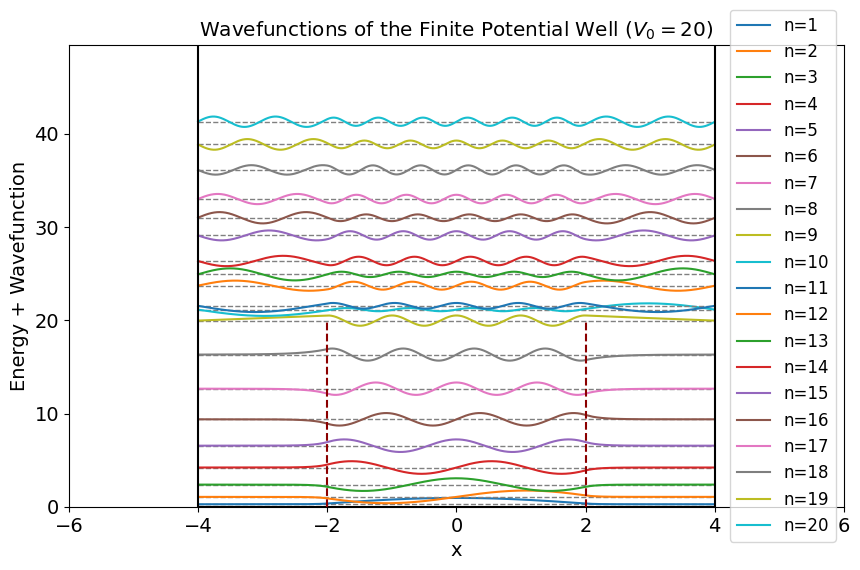

In [12]:
# Parameters
n_points = 2001         # Discretization of space (x) 
n_states = 20           # Number of states of interest
L = 4.0                 # Size of the box 
barrier_height = 20     # Height of the finite potential barrier

# Finite potential well 
x, V, energy_levels, wavefunctions = finite_potential_well(n_points, n_states, L, barrier_height)

# Calculating <p>, <p^2>, <x>, <x^2> and uncertainties 
average_x = calculate_average_x(x, wavefunctions)
average_x_squared = calculate_average_x_squared(x, wavefunctions)
uncertainties_x = calculate_uncertainty_x(x, wavefunctions)
average_p = calculate_average_momenta(x, wavefunctions)
average_p_squared = calculate_average_momenta_squared(x, wavefunctions)
uncertainties_p = calculate_uncertainty_p(x, wavefunctions) 
uncertainty_products = uncertainties_x * uncertainties_p


# Display relevant information 
for i in range(len(energy_levels)):
    energy = energy_levels[i] 
    x_avg = average_x[i]
    x2_avg = average_x_squared[i]
    sigma_x = uncertainties_x[i]
    p_avg = average_p[i]
    p2_avg= average_p_squared[i]
    sigma_p = uncertainties_p[i]

    row_info = [i+1, energy, abs(x_avg), x2_avg, sigma_x, abs(p_avg), p2_avg, sigma_p, sigma_p*sigma_x]
    
    if (i == 0): 
        print(f"n\tE(n)\t\t<x>\t<x^2>\tσx\t\t<p>\t<p^2>\tσp\t\tσxσp")
        print("-" * 95)
    print("{}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}".format(*row_info))
    if (i == len(energy_levels) - 1): print("\n")


# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 12})

for i in range(n_states):
    plt.hlines(y=energy_levels[i], xmin=-L, xmax=L, color='gray', linestyle='--', linewidth=1.0)
    plt.plot(x, wavefunctions[:, i] + energy_levels[i], label=f'n={i+1}')

# Define the boundaries of the (hard, infinite) box 
plt.vlines(-L, 0, 2*energy_levels[-1], color='black')
plt.vlines(L, 0, 2*energy_levels[-1], color='black')
plt.hlines(y=0, xmin=-L, xmax=L, color='black')

# Define where the barrier is 
plt.vlines(-L/2, 0, barrier_height, linestyle = '--', color='darkred')
plt.vlines(L/2, 0, barrier_height, linestyle = '--', color='darkred')

tick_locations = [-3*L/2, -L, -L/2, 0, L/2, L, 3*L/2]
ax.set_xticks(tick_locations)
plt.ylim(0, energy_levels[-1] * 1.2 )
plt.title('Wavefunctions of the Finite Potential Well ($V_0 = 20$)')
plt.xlabel('x')
plt.ylabel('Energy + Wavefunction')
plt.legend(loc = 'center right')
plt.show()

The wavefunctions for the shallow finite potential well with $V_0 = 20$ reveal fascinating quantum mechanical behaviors. For the bound states—those with energy lower than the barrier height—the wavefunctions are predominantly confined within the box. However, we also observe that these bound states "leak" slightly into the region outside the box, where the potential is greater than their energy. This behavior is a hallmark of quantum tunneling, a phenomenon where particles have a nonzero probability of existing in classically forbidden regions due to the wave-like nature of quantum mechanics.

In contrast, the higher energy states, with energies exceeding $V_0$, are no longer confined to the box and extend significantly into the external region. These unbound states represent particles that can escape the potential well entirely. The shapes of the wavefunctions for these states differ notably inside and outside of the potential well. Inside the well, the wavefunctions exhibit oscillatory behavior with shorter wavelengths, reflecting higher kinetic energy. Outside the well, the wavefunctions have larger wavelengths, indicating a transition to free-particle behavior. This contrast between bound and unbound states, and the distinctive wavefunction features in different regions, underscores the interplay between quantum mechanics and the shape of the potential landscape.

Our next step is to investigate this "leaking" effect of wavefunctions to classically forbidden regions. Like previously mentioned, it's more commonly referred to as quantum tunneling. The tunneling probability can easily be calculated by considering the probability that the particle is outside the box. 

In [13]:
def calculate_tunneling_probability(x, V, energy_levels, wavefunctions, n_state):
    # Select the energy level and corresponding wavefunction
    E_n = energy_levels[n_state]
    psi_n = wavefunctions[:, n_state]
    dx = x[1] - x[0]

    # Identify the regions where V(x) > E_n
    tunneling_region = V > E_n

    # Compute the tunneling probability
    tunneling_probability = np.sum(np.abs(psi_n[tunneling_region])**2 * dx)

    return tunneling_probability

In [14]:
for n in range(n_states):
    E_n = energy_levels[n]
    if (barrier_height > E_n): 
        tunneling_probability = calculate_tunneling_probability(x, V, energy_levels, wavefunctions, n)
        print(f"Tunneling probability for n = {n+1:>1} is {tunneling_probability*100:>.1f} %")


Tunneling probability for n = 1 is 0.1 %
Tunneling probability for n = 2 is 0.4 %
Tunneling probability for n = 3 is 0.9 %
Tunneling probability for n = 4 is 1.7 %
Tunneling probability for n = 5 is 2.9 %
Tunneling probability for n = 6 is 4.6 %
Tunneling probability for n = 7 is 7.3 %
Tunneling probability for n = 8 is 12.7 %
Tunneling probability for n = 9 is 38.9 %


The tunneling probabilities for the first few bound states reveal a clear trend that reflects the interplay between the particle's energy and the potential barrier height. For the lowest energy state ($n = 1$), the tunneling probability is smallest because the wavefunction is more tightly confined within the well, with most of its amplitude concentrated inside the box. As the energy level $n$ increases, the wavefunctions extend further, and the tunneling probability rises. This is because higher energy states have greater kinetic energy, allowing their wavefunctions to penetrate deeper into the classically forbidden region outside the well. The increasing tunneling probabilities with $n$ illustrate how bound states approach the threshold of becoming unbound as their energies approach the potential barrier height, $V_0$. This behavior is a direct consequence of quantum mechanics, where the wave-like nature of particles allows them to exist partially in regions forbidden by classical physics.

## 3. The Quantum Harmonic Oscillator

Having explored the finite and infinite potential wells, we now turn our attention to the quantum harmonic oscillator—one of the most fundamental and widely applicable models in quantum mechanics. Unlike the potential wells we’ve studied so far, the quantum harmonic oscillator describes a particle in a parabolic potential, $V(x) = \frac{1}{2} k x^2$, where $k$ represents the stiffness of the "spring." This potential is unbounded, meaning that it grows indefinitely as $|x|$ increases, and as a result, all quantum states are confined and discrete.

The quantum harmonic oscillator holds special significance because it provides an exact solution to the Schrödinger equation, and its principles extend to a wide range of physical systems. It models everything from the vibrations of atoms in a molecule to the quantization of electromagnetic fields in quantum electrodynamics. By solving and visualizing the wavefunctions and energy levels of the quantum harmonic oscillator, we’ll uncover its unique features, such as evenly spaced energy levels and wavefunctions that combine oscillatory and Gaussian-like behaviors. This exploration will not only deepen our understanding of quantum mechanics but also pave the way for studying more complex and realistic systems.

In [15]:
def quantum_harmonic_oscillator(n_points, n_states, k=1, x_min=-5, x_max=5):
    
    # Discretize the space 
    x = np.linspace(x_min, x_max, n_points)
    dx = x[1] - x[0]

    # Potential energy V(x) = 0.5 * k * x^2 for harmonic oscillator
    V = 0.5 * k * x**2 

    # Construct the Hamiltonian matrix using finite differences
    # Kinetic term: -1/(2m) d^2/dx^2 (set m=1, hbar=1 for simplicity)
    kinetic = (-2 * np.eye(n_points) + np.eye(n_points, k=1) + np.eye(n_points, k=-1)) / (-2 * dx**2)

    # Potential term: diagonal matrix of V
    potential = np.diag(V)
    
    # Total Hamiltonian
    H = kinetic + potential

    # Solve the eigenvalue problem on the larger mesh 
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Take the first n_states eigenvalues and eigenvectors
    energy_levels = eigenvalues[:n_states]
    wavefunctions = eigenvectors[:, :n_states]

    # Normalize the wavefunctions
    wavefunctions = wavefunctions / np.sqrt(np.sum(wavefunctions**2, axis=0) * dx)

    return x, V, energy_levels, wavefunctions


n	E(n)		<x>	<x^2>	σx		<p>	<p^2>	σp		σxσp
-----------------------------------------------------------------------------------------------
1	0.5000		0.0000	0.5000	0.7071		0.0000	0.5000	0.7071		0.5000
2	1.5000		0.0000	1.5000	1.2247		0.0000	1.5000	1.2247		1.5000
3	2.5000		0.0000	2.5000	1.5811		0.0000	2.5000	1.5811		2.5000
4	3.5000		0.0000	3.4999	1.8708		0.0000	3.5000	1.8708		3.5000
5	4.5000		0.0000	4.4997	2.1213		0.0000	4.5003	2.1214		4.5000
6	5.5000		0.0000	5.4982	2.3448		0.0000	5.5019	2.3456		5.5000
7	6.5005		0.0000	6.4904	2.5476		0.0000	6.5106	2.5516		6.5005
8	7.5027		0.0000	7.4582	2.7310		0.0000	7.5473	2.7472		7.5026
9	8.5110		0.0000	8.3551	2.8905		0.0000	8.6670	2.9440		8.5096
10	9.5355		0.0000	9.1003	3.0167		0.0000	9.9708	3.1577		9.5256




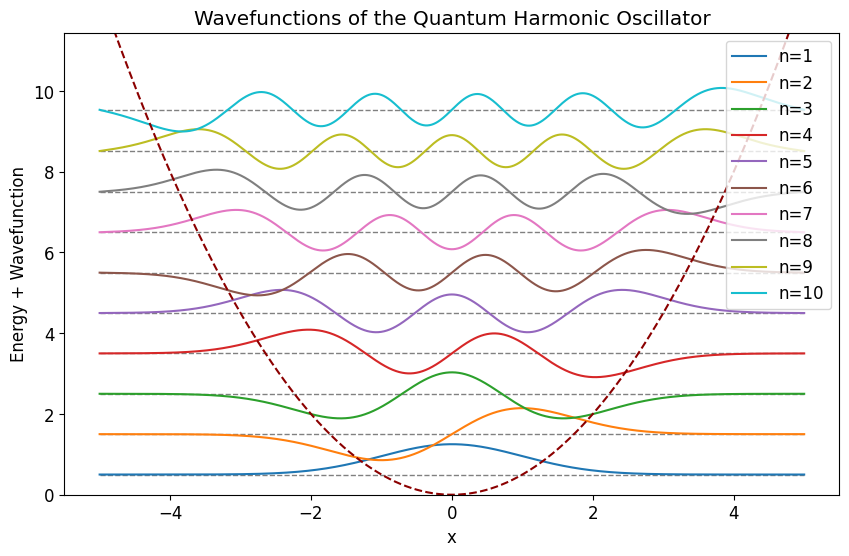

In [16]:
# Parameters
n_points = 2000         # Discretization of space (x) 
n_states = 10           # Number of states of interest

# The harmonic oscillator 
x, V, energy_levels, wavefunctions = quantum_harmonic_oscillator(n_points, n_states, k=1)

# Calculating <p>, <p^2>, <x>, <x^2> and uncertainties 
average_x = calculate_average_x(x, wavefunctions)
average_x_squared = calculate_average_x_squared(x, wavefunctions)
uncertainties_x = calculate_uncertainty_x(x, wavefunctions)
average_p = calculate_average_momenta(x, wavefunctions)
average_p_squared = calculate_average_momenta_squared(x, wavefunctions)
uncertainties_p = calculate_uncertainty_p(x, wavefunctions) 
uncertainty_products = uncertainties_x * uncertainties_p


# Display relevant information 
for i in range(len(energy_levels)):
    energy = energy_levels[i] 
    x_avg = average_x[i]
    x2_avg = average_x_squared[i]
    sigma_x = uncertainties_x[i]
    p_avg = average_p[i]
    p2_avg= average_p_squared[i]
    sigma_p = uncertainties_p[i]

    row_info = [i+1, energy, abs(x_avg), x2_avg, sigma_x, abs(p_avg), p2_avg, sigma_p, sigma_p*sigma_x]
    
    if (i == 0): 
        print(f"n\tE(n)\t\t<x>\t<x^2>\tσx\t\t<p>\t<p^2>\tσp\t\tσxσp")
        print("-" * 95)
    print("{}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}".format(*row_info))
    if (i == len(energy_levels) - 1): print("\n")


# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_states):
    plt.hlines(y=energy_levels[i], xmin=-5, xmax=5, color='gray', linestyle='--', linewidth=1.0)
    plt.plot(x, wavefunctions[:, i] + energy_levels[i], label=f'n={i+1}')

# Plotting the parabolic potential
plt.plot(x, V, color='darkred', linestyle = '--')

plt.ylim(0, energy_levels[-1] * 1.2 )
plt.title('Wavefunctions of the Quantum Harmonic Oscillator')
plt.xlabel('x')
plt.ylabel('Energy + Wavefunction')
plt.legend()
plt.show()

By visually inspecting the wavefunctions of the quantum harmonic oscillator alongside the parabolic potential $V(x) = \frac{1}{2} k x^2$, we can immediately observe several important features of quantum mechanics. Similar to the finite potential well, the wavefunctions are localized within regions where the particle's energy is comparable to the potential, and their amplitudes diminish rapidly in the classically forbidden regions. This behavior is consistent with the quantum mechanical principle that particles are most likely to be found in regions of lower potential energy. Furthermore, the oscillatory nature of the wavefunctions increases with the energy level $n$, reflecting the higher kinetic energy and more complex spatial behavior of particles in these states.

The next striking feature is how the spatial extent of the wavefunctions increases with $n$, leading to larger uncertainties in position ($\sigma_x$). This expansion is directly tied to the scaling laws of the quantum harmonic oscillator: as $n$ increases, the energy grows as $E_n = \hbar \omega (n + \frac{1}{2})$. And since $\langle x \rangle$ and $\langle p \rangle$ are both zero due to symmetry, the scaling for variances are given by: 

 - $\sigma_x^2 = (2n + 1) \displaystyle \frac{\hbar}{2 m \omega}$

 - $\sigma_p^2 = (2n + 1) \displaystyle \frac{m \hbar \omega}{2}$


Another very important observation is that the ground state of the quantum harmonic oscillator is the first state we've seen so far that truly minimizes Heisenberg's uncertainty principle, satisfying $\sigma_x \sigma_p \ge \frac{\hbar}{2}$. In this state, the uncertainties in position $\sigma_x$ and momentum $\sigma_p$ are perfectly balanced, representing the lowest possible product of uncertainties allowed by quantum mechanics. This occurs because the ground state wavefunction, a Gaussian, is symmetric and tightly localized in both position and momentum space, making it the most stable state with no excess energy. 

E = 1.0025 * n + -0.5088
Var(p) = 1.0344 * n + -0.6194
Var(x) = 0.9706 * n + -0.3981



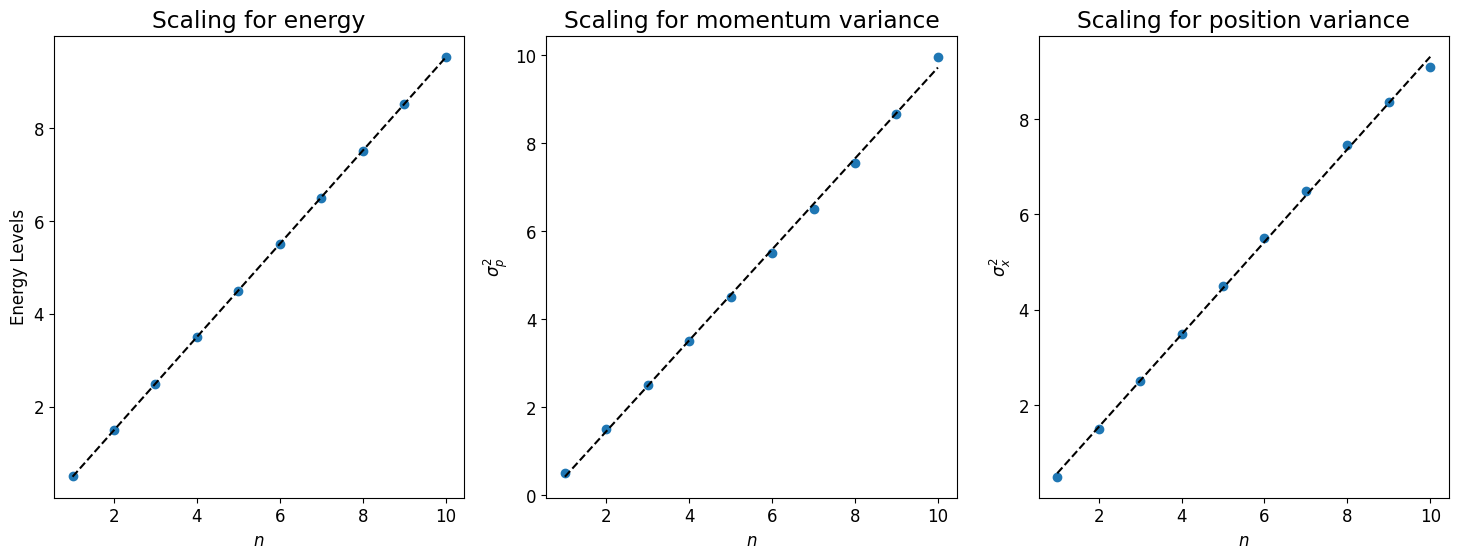

In [17]:
# Prepare fitting with n
n = np.linspace(1, n_states, n_states)

# Linear fitting to data points
def line_fit(x, a, b):
	return a * x + b

# Curve fitting with respect to n for all cases
fit_energy, _ = curve_fit(line_fit, n, energy_levels)
fit_uncertainty_p, _ = curve_fit(line_fit, n, average_p_squared)
fit_uncertainty_x, _ = curve_fit(line_fit, n, average_x_squared)

# Extracting fit parameters
a_ene, b_ene = fit_energy
a_p, b_p = fit_uncertainty_p
a_x, b_x = fit_uncertainty_x

# Creating a fit line for comparison
fit_line_ene = line_fit(n, a_ene, b_ene)
fit_line_p = line_fit(n, a_p, b_p)
fit_line_x = line_fit(n, a_x, b_x)

# Print fitting parameters
print(f"E = {a_ene:>.4f} * n + {b_ene:>.4f}")
print(f"Var(p) = {a_p:>.4f} * n + {b_p:>.4f}")
print(f"Var(x) = {a_x:>.4f} * n + {b_x:>.4f}\n")

### Plotting ###
fig, ax = plt.subplots(1,3, figsize=(18, 6))
plt.rcParams.update({'font.size': 14})

# Scaling for energy 
ax[0].scatter(n, energy_levels)
ax[0].plot(n, fit_line_ene, '--', color='k')
ax[0].set_title('Scaling for energy')
ax[0].set_xlabel('$n$')
ax[0].set_ylabel('Energy Levels')

# Scaling for momentum variance
ax[1].scatter(n, average_p_squared)
ax[1].plot(n, fit_line_p, '--', color='k')
ax[1].set_title('Scaling for momentum variance')
ax[1].set_xlabel('$n$')
ax[1].set_ylabel('$\sigma_p^2$')

# Scaling for position variance 
ax[2].scatter(n, average_x_squared)
ax[2].plot(n, fit_line_x, '--', color='k')
ax[2].set_title('Scaling for position variance')
ax[2].set_xlabel('$n$')
ax[2].set_ylabel('$\sigma_x^2$')

plt.show()

We can see from the all three quantities, $E_n$, $\sigma_x^2$, and $\sigma_p^2$ scale linearly with $n$, in line with the known scaling laws governing the quantum harmonic oscillator. We can also take a look at the tunneling probabilities for the wavefunctions of the harmonic oscillator.  


In [18]:
for n in range(n_states):
    E_n = energy_levels[n] 
    tunneling_probability = calculate_tunneling_probability(x, V, energy_levels, wavefunctions, n)
    print(f"Tunneling probability for n = {n+1:>1} is {tunneling_probability*100:>.1f} %")

Tunneling probability for n = 1 is 15.7 %
Tunneling probability for n = 2 is 11.2 %
Tunneling probability for n = 3 is 9.5 %
Tunneling probability for n = 4 is 8.5 %
Tunneling probability for n = 5 is 7.8 %
Tunneling probability for n = 6 is 7.4 %
Tunneling probability for n = 7 is 6.9 %
Tunneling probability for n = 8 is 6.5 %
Tunneling probability for n = 9 is 5.5 %
Tunneling probability for n = 10 is 3.9 %


The tunneling probabilities for the first ten states of the quantum harmonic oscillator reveal that lower energy states have higher tunneling probabilities. As the energy level $n$ increases, the wavefunctions become more concentrated in the classically allowed region, resulting in reduced tunneling probabilities despite their increasing spatial extent. 

## 4. Arbitrary Potential Wells

Having explored the infinite and finite potential wells and the quantum harmonic oscillator, we can now extend our logic to arbitrary potential wells, where the shape of the potential $V(x)$ can take on virtually any form. These systems are particularly interesting because they allow us to model real-world quantum systems with irregular or user-defined potentials (which usually require more than just a one-dimensional approach), such as atoms in asymmetric traps or electrons in engineered nanostructures. Unlike the harmonic oscillator or finite potential wells, where analytical solutions may exist, arbitrary potentials often require numerical methods similar to the ones we use here to solve the Schrödinger equation. In this next section, we will develop and implement a framework to numerically compute and visualize the wavefunctions and energy levels for arbitrary potentials, building on the tools we've established so far. This approach opens the door to exploring a wide range of quantum behaviors and tailoring the potential to specific physical scenarios.

In [19]:
def arbitrary_potential_well(n_states, x, V):

    ### Both the region of space (x) and V(x) have 
    ### to be defined and given as an input by the user 

    # Check to make sure lengths and shapes match between the x, V
    assert(V.shape == x.shape)
    n_points = len(V)
    
    # Infinitesimal dx 
    dx = x[1] - x[0]
    
    # Construct the Hamiltonian matrix using finite differences
    # Kinetic term: -1/(2m) d^2/dx^2 (set m=1, hbar=1 for simplicity)
    kinetic = (-2 * np.eye(n_points) + np.eye(n_points, k=1) + np.eye(n_points, k=-1)) / (-2 * dx**2)

    # Potential term: diagonal matrix of V
    potential = np.diag(V)
    
    # Total Hamiltonian
    H = kinetic + potential

    # Solve the eigenvalue problem on the larger mesh 
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Take the first n_states eigenvalues and eigenvectors
    energy_levels = eigenvalues[:n_states]
    wavefunctions = eigenvectors[:, :n_states]

    # Normalize the wavefunctions
    wavefunctions = wavefunctions / np.sqrt(np.sum(wavefunctions**2, axis=0) * dx)

    return energy_levels, wavefunctions

We now implemented the function to numerically solve the Schrödinger equation for a particle in an arbitrary potential. Note that it requires the user to define the region of space and the potential beforehand. Below are some functions that create different potential shapes, a Gaussian, an inverted cosine, and finally $V(x) = |x|$. Here is the opportunity to create more. Feel free to add your own user-defined potential below and test to see how the solutions to your potential look like. 

In [20]:
def construct_gaussian_potential(x, amplitude, mean, std_deviation):
    V = amplitude * np.exp(-((x - mean)**2)/(2 * std_deviation**2))
    return V

def construct_inverted_cosine_potential(x, period, amplitude, phase=0):
    V = - amplitude * np.cos(2 * np.pi * x / period + phase)
    return V

def construct_abs_potential(x, k):
    V = k * abs(x)
    return V
    

n	E(n)		<x>	<x^2>	σx		<p>	<p^2>	σp		σxσp
-----------------------------------------------------------------------------------------------
1	0.2604		0.0000	8.5643	2.9265		0.0000	0.4592	0.6777		1.9832
2	0.2610		0.0000	8.5804	2.9292		0.0000	0.4645	0.6815		1.9963
3	1.0202		0.0000	9.0094	3.0016		0.0000	1.7799	1.3341		4.0045
4	1.0241		0.0000	9.0494	3.0082		0.0000	1.8139	1.3468		4.0515
5	2.2197		0.0000	8.6965	2.9490		0.0000	3.7792	1.9440		5.7329
6	2.2378		0.0000	8.8259	2.9708		0.0000	3.9357	1.9839		5.8938
7	3.7615		0.0000	8.0634	2.8396		0.0000	6.0730	2.4644		6.9978
8	3.8377		0.0000	8.4828	2.9125		0.0000	6.7104	2.5904		7.5447
9	5.4960		0.0000	7.1133	2.6671		0.0000	8.1013	2.8463		7.5913
10	5.7720		0.0000	8.1780	2.8597		0.0000	10.1072	3.1792		9.0916




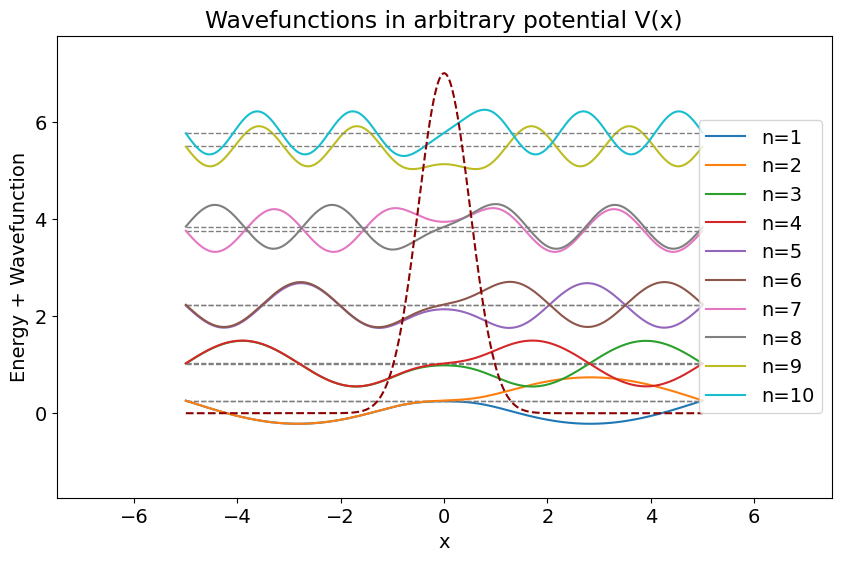

In [21]:
# Define parameters
x_min = -5
x_max = 5
n_points = 2000
n_states = 10

# Define the region of space
x = np.linspace(x_min, x_max, n_points)

# Define the potential 
amplitude = 7
mean = 0
std_deviation = 0.5

V = construct_gaussian_potential(x, amplitude, mean, std_deviation)

# Solve the arbitrary potential well 
energy_levels, wavefunctions = arbitrary_potential_well(n_states, x, V)


# Calculating <p>, <p^2>, <x>, <x^2> and uncertainties 
average_x = calculate_average_x(x, wavefunctions)
average_x_squared = calculate_average_x_squared(x, wavefunctions)
uncertainties_x = calculate_uncertainty_x(x, wavefunctions)
average_p = calculate_average_momenta(x, wavefunctions)
average_p_squared = calculate_average_momenta_squared(x, wavefunctions)
uncertainties_p = calculate_uncertainty_p(x, wavefunctions) 
uncertainty_products = uncertainties_x * uncertainties_p


# Display relevant information 
for i in range(len(energy_levels)):
    energy = energy_levels[i] 
    x_avg = average_x[i]
    x2_avg = average_x_squared[i]
    sigma_x = uncertainties_x[i]
    p_avg = average_p[i]
    p2_avg= average_p_squared[i]
    sigma_p = uncertainties_p[i]

    row_info = [i+1, energy, abs(x_avg), x2_avg, sigma_x, abs(p_avg), p2_avg, sigma_p, sigma_p*sigma_x]
    
    if (i == 0): 
        print(f"n\tE(n)\t\t<x>\t<x^2>\tσx\t\t<p>\t<p^2>\tσp\t\tσxσp")
        print("-" * 95)
    print("{}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}\t{:>.4f}\t{:>.4f}\t\t{:>.4f}".format(*row_info))
    if (i == len(energy_levels) - 1): print("\n")


# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_states):
    plt.hlines(y=energy_levels[i], xmin=x_min, xmax=x_max, color='gray', linestyle='--', linewidth=1.0)
    plt.plot(x, wavefunctions[:, i] + energy_levels[i], label=f'n={i+1}')

# Plotting the parabolic potential
plt.plot(x, V, color='darkred', linestyle = '--')

plt.ylim(energy_levels[0] - 2, energy_levels[-1] + 2 )
plt.xlim(x_min * 1.5, x_max * 1.5)
plt.title('Wavefunctions in arbitrary potential V(x)')
plt.xlabel('x')
plt.ylabel('Energy + Wavefunction')
plt.legend(loc = 'center right')
plt.show()